In [3]:
import os

os.chdir("..")
%load_ext autoreload

In [132]:
import matplotlib.pyplot as plt
import shutil
import comet_ml
import numpy as np
import seaborn as sb
import pandas as pd
import torch
from monai.transforms import Rotate90, Compose
from src.transforms.load import FinetuneTransform, ToSoftLabel
from src.network.sfcn_net import SFCNModel, SFCNEncoder, SFCNClassifier, SFCNBlock, SFCNHeadBlock
from src.network.archi import Encoder, Model, Classifier
from src.network.cnn_net import CNNModel
from src.training.lightning_logic import PretrainingTask
from src.utils.comet import get_pretrain_task
from src.config import IM_SHAPE
api = comet_ml.api.API(
    api_key="WmA69YL7Rj2AfKqwILBjhJM3k",
)

In [166]:
net = get_pretrain_task("SFCN", 4,"estimate-motion-adjusted-lr")

COMET INFO: Downloading experiment model 'SFCNModel' ...
COMET INFO: Unzipping model to '/home/cbricout/scratch/estimate-motion-adjusted-lr-4/SFCNModel' ...
COMET INFO: done!


In [168]:
net.model.mc_dropout()
torch.jit.trace(net.model, torch.rand(1, *IM_SHAPE).cuda()).save("sfcn-export")
net = torch.jit.load("sfcn-export")
shutil.rmtree('/home/cbricout/scratch')

c:\Users\Brico\miniconda3\envs\bowl\Lib\site-packages\torch\jit\_trace.py:1093: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 40 / 40 (100.0%)
Greatest absolute difference: 416.1980743408203 at index (0, 35) (up to 1e-05 allowed)
Greatest relative difference: 154.33819678965378 at index (0, 27) (up to 1e-05 allowed)
  _check_trace(


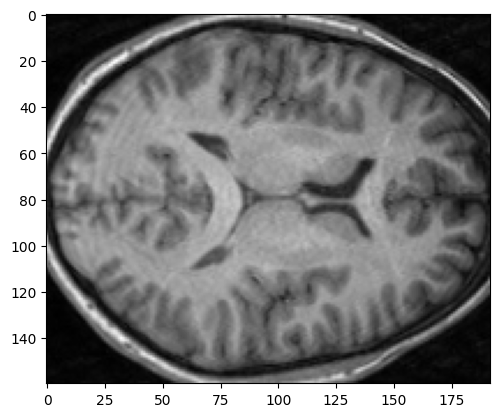

In [88]:
load = FinetuneTransform()
to_soft:ToSoftLabel = ToSoftLabel.base_config()
std = load({"data":r"C:\Users\Brico\Downloads\sub-067018_ses-standard_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz"})['data']
mot1 = load({"data":r"C:\Users\Brico\Downloads\sub-067018_ses-headmotion1_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz"})['data']
mot2 = load({"data":r"C:\Users\Brico\Downloads\sub-067018_ses-headmotion2_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz"})['data']
plt.imshow(mot2[0,:,:,75], cmap="gray")

c:\Users\Brico\miniconda3\envs\bowl\Lib\site-packages\torch\_tensor.py:1386: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


0.9202841969020938
1.0452905675386501
0.8692097006046936


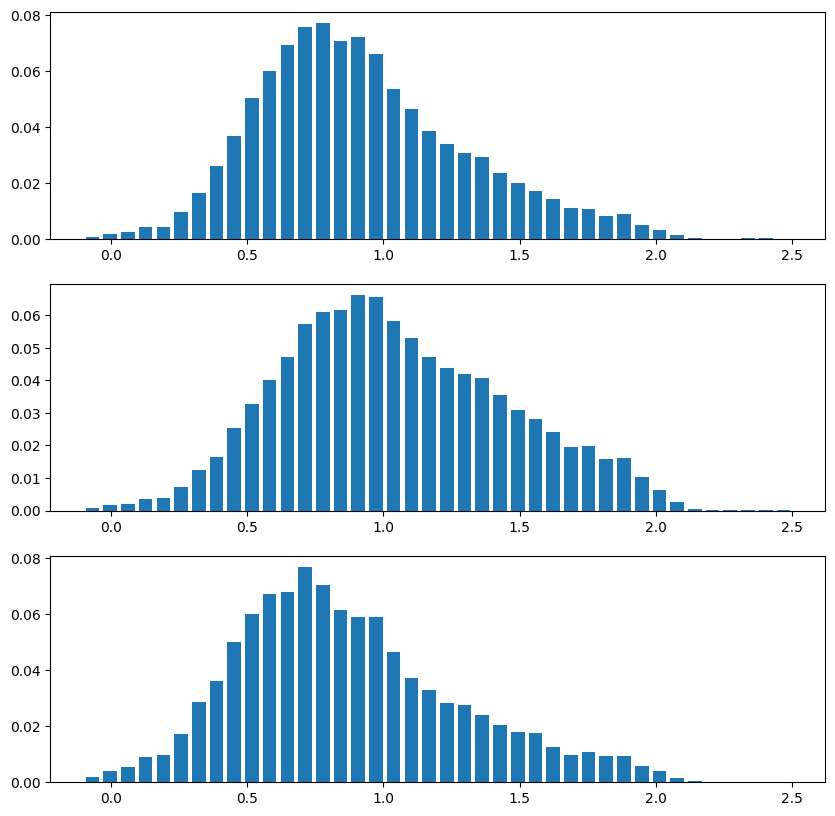

In [105]:
model = net
model.eval()
model.cpu()
labels=[]
with torch.no_grad():
    for volume in (std, mot1, mot2):   
        v =volume.float().unsqueeze(0)
        raw_label = model(v)
        label =  torch.nn.functional.softmax(raw_label.flatten()).numpy()
        motion =(label*to_soft.bin_centers).sum() / label.sum()
        labels.append(label)
        # labels.append(raw_label[0])

        print(motion)

plt.figure(figsize=(10,10))
for i,l in enumerate(labels):
    plt.subplot(3,1,i+1)
    plt.bar(x=to_soft.bin_centers, height=l, width=0.05)
    # plt.ylim((0,0.12))

In [74]:
labels

[metatensor([7.5852e-04, 1.7174e-03, 2.2390e-03, 4.2836e-03, 4.1898e-03, 9.7239e-03,
         1.6410e-02, 2.5981e-02, 3.6877e-02, 5.0507e-02, 6.0196e-02, 6.9310e-02,
         7.5941e-02, 7.7185e-02, 7.0727e-02, 7.2364e-02, 6.6142e-02, 5.3667e-02,
         4.6347e-02, 3.8684e-02, 3.3786e-02, 3.0608e-02, 2.9102e-02, 2.3372e-02,
         1.9809e-02, 1.7191e-02, 1.4228e-02, 1.1022e-02, 1.0482e-02, 8.2657e-03,
         8.8261e-03, 4.8678e-03, 3.1629e-03, 1.3395e-03, 3.0820e-04, 8.6073e-05,
         3.9054e-05, 1.0204e-04, 1.1794e-04, 3.4886e-05]),
 metatensor([7.8361e-04, 1.5744e-03, 1.9588e-03, 3.5869e-03, 3.7838e-03, 7.1527e-03,
         1.2342e-02, 1.6314e-02, 2.5217e-02, 3.2676e-02, 4.0060e-02, 4.7235e-02,
         5.7351e-02, 6.0966e-02, 6.1614e-02, 6.6276e-02, 6.5720e-02, 5.8346e-02,
         5.2992e-02, 4.7114e-02, 4.3750e-02, 4.1857e-02, 4.0862e-02, 3.5608e-02,
         3.0908e-02, 2.8138e-02, 2.4033e-02, 1.9427e-02, 1.9691e-02, 1.5980e-02,
         1.6229e-02, 1.0323e-02, 6.4144e-0

In [161]:
from_slic:np.ndarray = np.load("to_load.npy")


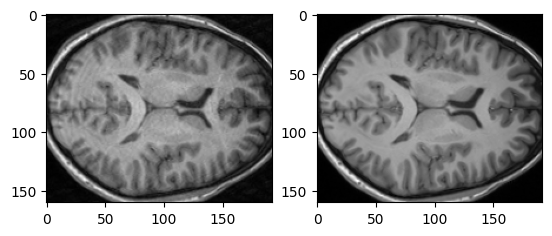

In [164]:
# correct = Compose([
# Rotate90(k=1,spatial_axes=(0,2)),
# # Rotate90(spatial_axes=(0,1))
# ])
from_slic_t :np.ndarray= from_slic.transpose(0,1,4,3,2)
plt.subplot(1,2,1)
plt.imshow(mot2[0,:,:,75], cmap="gray")
plt.subplot(1,2,2)
plt.imshow(from_slic_t[0,0,:,:,75], cmap="gray")

C:\Users\Brico\AppData\Local\Temp\ipykernel_37456\4098712900.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  label =  torch.nn.functional.softmax(raw_label.flatten()).numpy()


<BarContainer object of 40 artists>

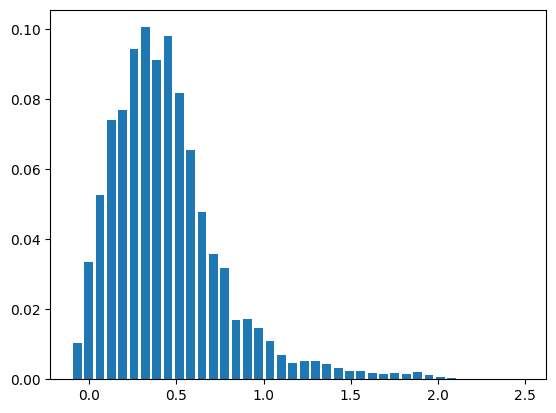

In [103]:
with torch.no_grad():
    raw_label = model(torch.FloatTensor(from_slic))
    label =  torch.nn.functional.softmax(raw_label.flatten()).numpy()
    motion =(label*to_soft.bin_centers).sum() / label.sum()
plt.bar(x=to_soft.bin_centers, height=label, width=0.05)

<BarContainer object of 40 artists>

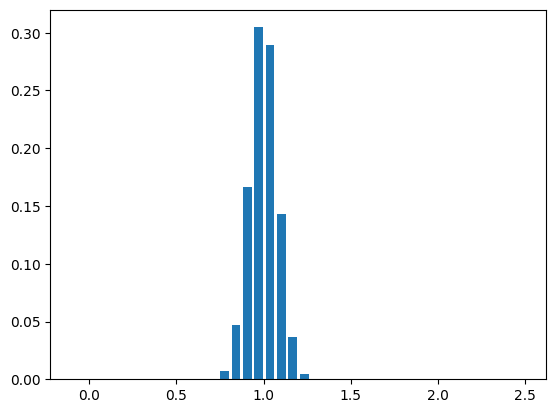

In [120]:
plt.bar(x=to_soft.bin_centers, height=to_soft.value_to_softlabel(1), width=0.05)
